In [1]:
import postprocessing
import os.path
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.animation import FuncAnimation
import yt
import glob
import pandas as pd
import math
from matplotlib.backends.backend_pdf import PdfPages
mpl.rcParams['figure.dpi'] = 100
import inspect

from mpl_toolkits.axes_grid1 import Size, Divider

/home/dbeckers/.conda/envs/postprocessing_v2/lib/python3.9/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home/dbeckers/.config/yt/ytrc is deprecated in favor of /home/dbeckers/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


In [2]:
yt.set_log_level(50)

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
class TwoDimScalarDistribution:
    def __init__(self, name, u, v, x0, y0, amplitude, x_width, y_width, x_wavenumber, y_wavenumber):
        self.name = name
        self.u = u
        self.v = v
        self.x0 = x0
        self.y0 = y0
        self.amplitude = amplitude
        self.x_width = x_width
        self.y_width = y_width
        self.x_wavenumber = x_wavenumber
        self.y_wavenumber = y_wavenumber

In [5]:
class TwoDimGaussianPulse(TwoDimScalarDistribution):
    def exact_solution(self, x, y, t):
        x_convected_distance = self.u * t
        y_convected_distance = self.v * t
        if ((abs((x-x_convected_distance) - self.x0) < 6 * self.x_width) and (abs((y-y_convected_distance) - self.y0) < 6 * self.y_width)):
            return self.amplitude * math.exp( - ((x - x_convected_distance) - self.x0) ** 2 / (2 * self.x_width ** 2) - ((y - y_convected_distance) - self.y0) ** 2 / (2 * self.y_width ** 2))
        else:
            return 0.0

In [6]:
root_dir = '/scratch/dbeckers/scalar_advection'

In [7]:
x_exact = np.linspace(0, 1, num=2000)
y_exact = np.linspace(-0.5, 0.5, num=2000)
ray_exact = [math.sqrt(x_i**2 + (y_i+0.5)**2) for x_i,y_i in zip(x_exact,y_exact)]
lw_exact = 0.5
ls_exact = 'dashed'

## 2D Gaussian pulse uniform

In [14]:
twodimgaussianpulse_45_045 = TwoDimGaussianPulse("twodimgaussianpulse_45_degrees_CFL_0.45",math.cos(45*math.pi/180),math.sin(45*math.pi/180),0.5-0.25*math.cos(45*math.pi/180),-0.25*math.sin(45*math.pi/180),1.0,0.01,0.01,0,0)
twodimgaussianpulse_0_045 = TwoDimGaussianPulse("twodimgaussianpulse_0_degrees_CFL_0.45",1.0,0.0,0.25,0.0,1.0,0.01,0.01,0,0)
case_dir_45 = twodimgaussianpulse_45_045.name+"/uniform"
case_dir_0 = twodimgaussianpulse_0_045.name+"/uniform"
methods = ['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','godunov_bds']
grid_sizes = [128]
maxlevel = 0
withglobal = False
plt_count_list = postprocessing.batch_plt_count(root_dir,case_dir_45,methods,grid_sizes)
minpltcount = min([plt_count_grid_size for plt_count_method in plt_count_list for plt_count_grid_size in plt_count_method])

#### Distribution

t = 0

In [30]:
%%capture
fig,ax = plt.subplots(figsize=(9,7))
ds_slice = postprocessing.load_plt(f'{root_dir}/godunov_ppm/{case_dir_45}/nx_128',0)
postprocessing.setup_slice_plot(fig,ax,ds_slice,'boxlib','temperature',[-0.2,0.2],size=5,annotate_ray=True,ray_start=(0,-0.5,0),ray_end=(1,0.5,0))

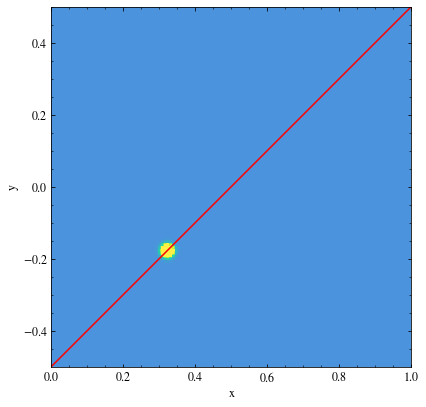

In [31]:
fig

In [32]:
fig.savefig(f'{twodimgaussianpulse_45_045.name}_uniform_initial.png',dpi=300)

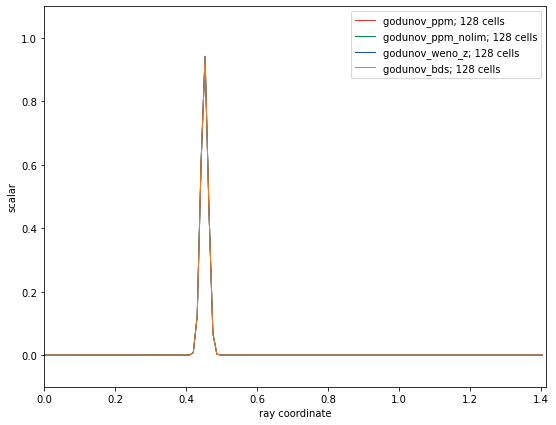

In [18]:
fig,ax = plt.subplots(figsize=(9,7))
postprocessing.batch_plot_ray(ax,root_dir,case_dir_45,methods,grid_sizes,0,(0,-0.5,0),(1,0.5,0),use_ray_coord=True,colormethods=True,ylim=[-0.1,1.1],variable='temperature')
fig.savefig(f'{twodimgaussianpulse_45_045.name}_uniform_distribution_initial.png',dpi=300)

t = 0.5

In [27]:
%%capture
fig,ax = plt.subplots(figsize=(9,7))
ds_slice = postprocessing.load_plt(f'{root_dir}/godunov_ppm/{case_dir_45}/nx_128',-1)
postprocessing.setup_slice_plot(fig,ax,ds_slice,'boxlib','temperature',[-0.2,0.2],size=5,annotate_ray=True,ray_start=(0,-0.5,0),ray_end=(1,0.5,0))

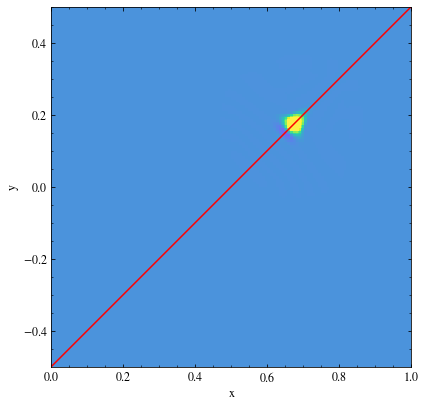

In [28]:
fig

In [29]:
fig.savefig(f'{twodimgaussianpulse_45_045.name}_uniform_final.png',dpi=300)

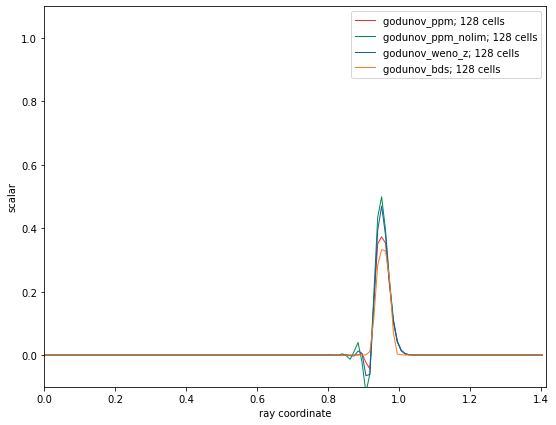

In [16]:
fig,ax = plt.subplots(figsize=(9,7))
postprocessing.batch_plot_ray(ax,root_dir,case_dir_45,methods,grid_sizes,-1,(0,-0.5,0),(1,0.5,0),use_ray_coord=True,colormethods=True,ylim=[-0.1,1.1],variable='temperature')
fig.savefig(f'{twodimgaussianpulse_45_045.name}_uniform_distribution_final.png',dpi=300)

['twodimgaussianpulse_45_degrees_CFL_0.45_uniform_final_zoom_ppm.png']

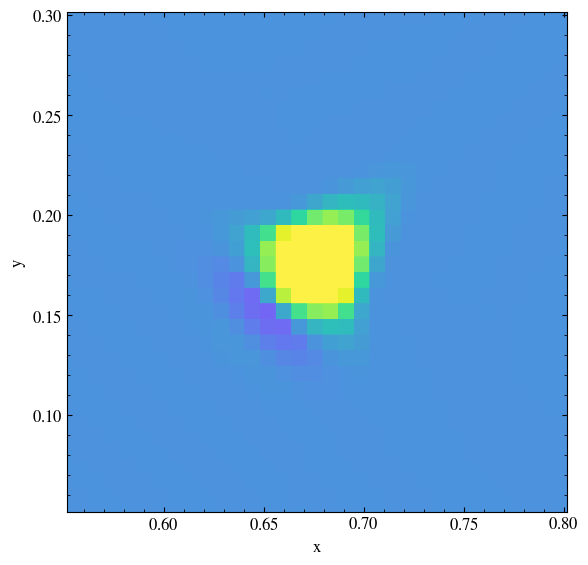

In [64]:
fig,ax = plt.subplots(figsize=(9,7))
ds_slice = postprocessing.load_plt(f'{root_dir}/godunov_ppm/{case_dir_45}/nx_128',-1)
slp = postprocessing.setup_slice_plot(fig,ax,ds_slice,'boxlib','temperature',[-0.2,0.2],size=5,annotate_ray=False,ray_start=(0,-0.5,0),ray_end=(1,0.5,0),center=(0.5+0.1767766952966369,0.17677669529663687,0),width=(0.25,"cm"))
slp.save(f'{twodimgaussianpulse_45_045.name}_uniform_final_zoom_ppm.png')

['twodimgaussianpulse_45_degrees_CFL_0.45_uniform_final_zoom_weno_z.png']

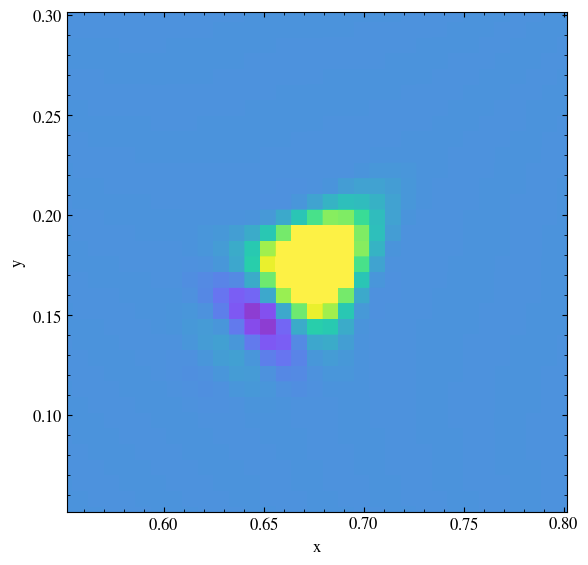

In [65]:
fig,ax = plt.subplots(figsize=(9,7))
ds_slice = postprocessing.load_plt(f'{root_dir}/godunov_weno_z/{case_dir_45}/nx_128',-1)
slp = postprocessing.setup_slice_plot(fig,ax,ds_slice,'boxlib','temperature',[-0.2,0.2],size=5,annotate_ray=False,ray_start=(0,-0.5,0),ray_end=(1,0.5,0),center=(0.5+0.1767766952966369,0.17677669529663687,0),width=(0.25,"cm"))
slp.save(f'{twodimgaussianpulse_45_045.name}_uniform_final_zoom_weno_z.png')

In [ ]:
fig,ax = plt.subplots(figsize=(9,7))
ds_slice = postprocessing.load_plt(f'{root_dir}/godunov_bds/{case_dir_45}/nx_128',-1)
slp = postprocessing.setup_slice_plot(fig,ax,ds_slice,'boxlib','temperature',[-0.2,0.2],size=5,annotate_ray=False,ray_start=(0,-0.5,0),ray_end=(1,0.5,0),center=(0.5+0.1767766952966369,0.17677669529663687,0),width=(0.25,"cm"))
slp.save(f'{twodimgaussianpulse_45_045.name}_uniform_final_zoom_bds.png')

#### Error convergence 0 degrees

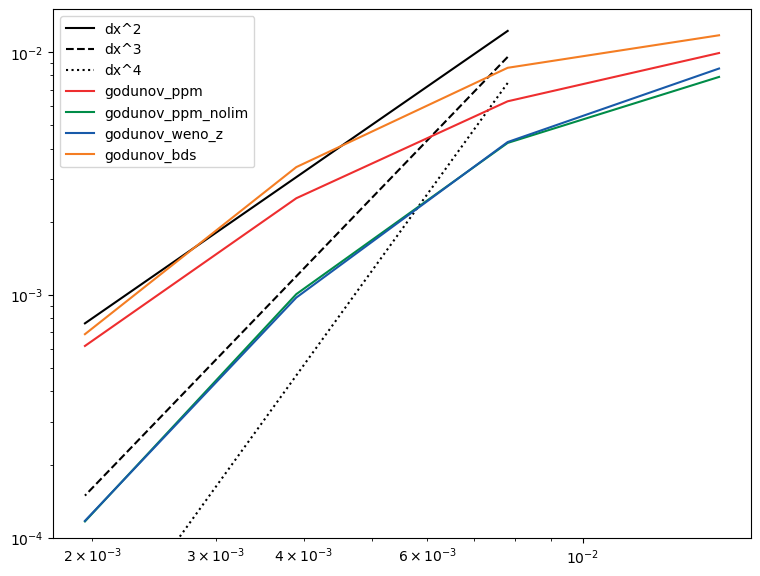

In [68]:
grid_sizes = [64,128,256,512]
dx_list = [1.0/grid_size for grid_size in grid_sizes[1:]]
error_list = postprocessing.batch_load_error('error.log',root_dir,case_dir_0,methods,grid_sizes,withglobal=False)
fig,ax = plt.subplots(figsize=[9,7])
ax.plot(dx_list,[2e2*dx**2 for dx in dx_list],label='dx^2',linestyle='solid',color='black')
ax.plot(dx_list,[2e4*dx**3 for dx in dx_list],label='dx^3',linestyle='dashed',color='black')
ax.plot(dx_list,[2e6*dx**4 for dx in dx_list],label='dx^4',linestyle='dotted',color='black')
for i_method in range(len(methods)):
    ax.plot([1/grid_size for grid_size in grid_sizes],[df_error_grid['error_var_0_level_0'].values[-1] for df_error_grid in error_list[i_method]],label=methods[i_method],color=postprocessing.color_list[i_method])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,1.5e-2])
ax.legend()
fig.savefig(f'{twodimgaussianpulse_45_045.name}_uniform_convergence.png',dpi=300)

#### Error convergence 45 degrees

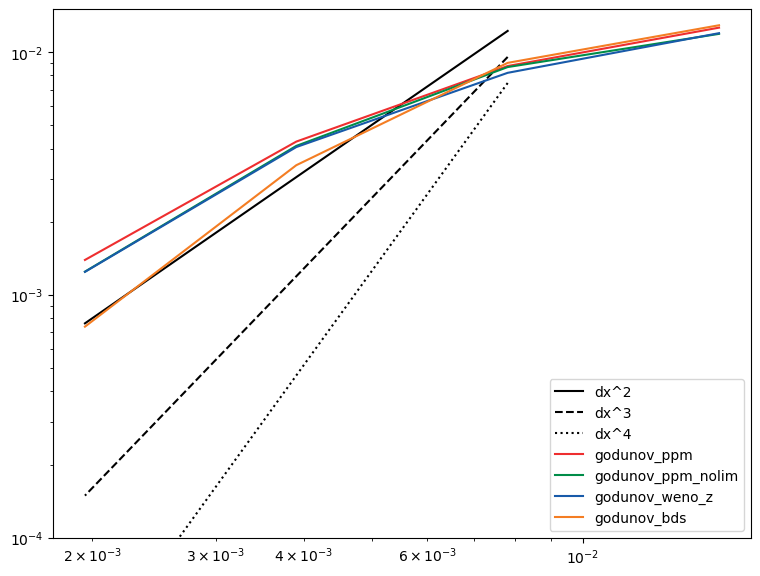

In [69]:
dx_list = [1.0/grid_size for grid_size in grid_sizes[1:]]
error_list = postprocessing.batch_load_error('error.log',root_dir,case_dir_45,methods,grid_sizes,withglobal=False)
fig,ax = plt.subplots(figsize=[9,7])
ax.plot(dx_list,[2e2*dx**2 for dx in dx_list],label='dx^2',linestyle='solid',color='black')
ax.plot(dx_list,[2e4*dx**3 for dx in dx_list],label='dx^3',linestyle='dashed',color='black')
ax.plot(dx_list,[2e6*dx**4 for dx in dx_list],label='dx^4',linestyle='dotted',color='black')
for i_method in range(len(methods)):
    ax.plot([1/grid_size for grid_size in grid_sizes],[df_error_grid['error_var_0_level_0'].values[-1] for df_error_grid in error_list[i_method]],label=methods[i_method],color=postprocessing.color_list[i_method])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,1.5e-2])
ax.legend()
fig.savefig(f'{twodimgaussianpulse_45_045.name}_uniform_convergence.png',dpi=300)

#### Error vs angle

In [9]:
angles = range(0,50,5)
grid_sizes = [256,512]

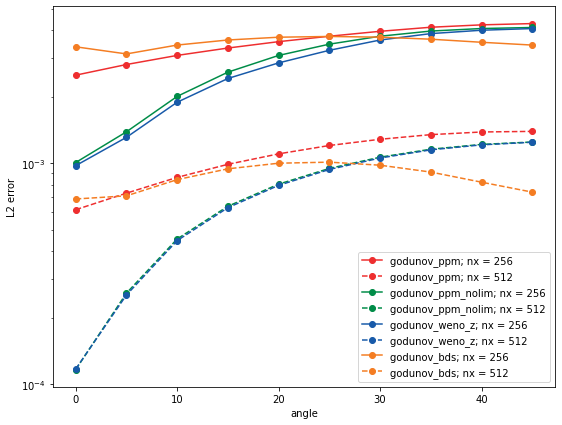

In [10]:
fig, ax = plt.subplots(figsize=(9,7))

for i_method in range(len(methods)):
    for i_grid_size in range(len(grid_sizes)):
        error_method = []
        for angle in angles:
            case_dir = f'twodimgaussianpulse_{angle}_degrees_CFL_0.45/uniform'
            error_list = postprocessing.batch_load_error('error.log',root_dir,case_dir,[methods[i_method]],[grid_sizes[i_grid_size]],withglobal=False)
            error_method.append(error_list[0][0]['error_var_0_level_0'].values[-1])
        ax.plot(angles,error_method,label=f'{methods[i_method]}; nx = {grid_sizes[i_grid_size]}',marker='o',color=postprocessing.color_list[i_method],linestyle=postprocessing.linestyle_list[i_grid_size])
        
ax.legend()
ax.set_xlabel('angle')
ax.set_ylabel('L2 error')
ax.set_yscale('log')
fig.savefig(f'twodimgaussianpulse_uniform_angle_error.png',dpi=300)

#### Maximum vs angle

In [11]:
max_all = []
min_all = []
for i_method in range(len(methods)):
    max_method = []
    min_method = []
    print(methods[i_method])
    for i_grid_size in range(len(grid_sizes)):
        max_angles = []
        min_angles = []
        print(grid_sizes[i_grid_size])
        for angle in angles:
            ds = postprocessing.load_plt(f'{root_dir}/{methods[i_method]}/twodimgaussianpulse_{angle}_degrees_CFL_0.45/uniform/nx_{grid_sizes[i_grid_size]}',-1)
            df = postprocessing.sample_ray(ds,(0.5+0.15*math.cos(angle*math.pi/180),0.15*math.sin(angle*math.pi/180),0),(0.5+0.35*math.cos(angle*math.pi/180),0.35*math.sin(angle*math.pi/180),0))
            max_angles.append(max(df['temperature']))
            min_angles.append(min(df['temperature']))
        max_method.append(max_angles)
        min_method.append(min_angles)
    max_all.append(max_method)
    min_all.append(min_method)

godunov_ppm
256
512
godunov_ppm_nolim
256
512
godunov_weno_z
256
512
godunov_bds
256
512


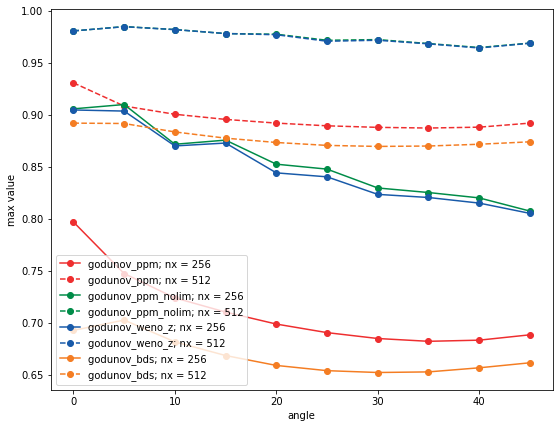

In [12]:
fig, ax = plt.subplots(figsize=(9,7))
for i_method in range(len(methods)):
    for i_grid_size in range(len(grid_sizes)):
        ax.plot(angles,max_all[i_method][i_grid_size],label=f'{methods[i_method]}; nx = {grid_sizes[i_grid_size]}',marker='o',color=postprocessing.color_list[i_method],linestyle=postprocessing.linestyle_list[i_grid_size])
        
ax.legend()
ax.set_xlabel('angle')
ax.set_ylabel('max value')
fig.savefig(f'twodimgaussianpulse_uniform_angle_max.png',dpi=300)

#### Minimum vs angle

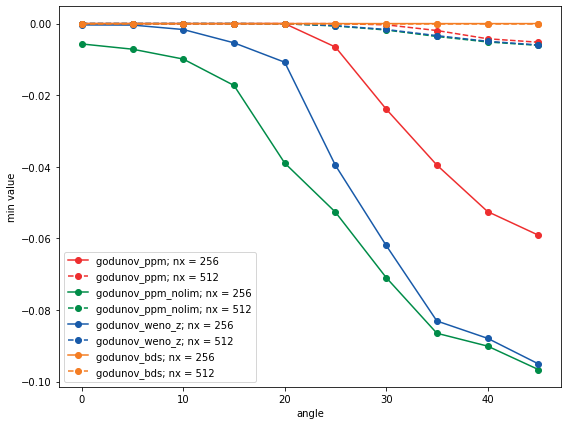

In [13]:
fig, ax = plt.subplots(figsize=(9,7))
for i_method in range(len(methods)):
    for i_grid_size in range(len(grid_sizes)):
        ax.plot(angles,min_all[i_method][i_grid_size],label=f'{methods[i_method]}; nx = {grid_sizes[i_grid_size]}',marker='o',color=postprocessing.color_list[i_method],linestyle=postprocessing.linestyle_list[i_grid_size])
        
ax.legend()
ax.set_xlabel('angle')
ax.set_ylabel('min value')
fig.savefig(f'twodimgaussianpulse_uniform_angle_max.png',dpi=300)

In [ ]:
ds = postprocessing.load_plt(f'{root_dir}/{methods[i_method]}/twodimgaussianpulse_{angle}_degrees_CFL_0.45/uniform/nx_{grid_sizes[i_grid_size]}',-1)

In [9]:
def postprocess_dist(case,idx,root_dir,methods,grid_types,grid_sizes,
                ax,line_styles,line_colors,line_widths,plotting=True,line_configuration=1,print_dir=False,ray_start=(0,0,0),ray_end=(1,0,0)):
    t_list = []
    ray_coord_list = []
    s_list = []
    ds_list = []
    
    i_method = -1
    for method in methods:
        i_method += 1
        
        t_list_method = []
        ray_coord_list_method = []
        s_list_method = []
        ds_list_method = []

        i_grid_type = -1
        for grid_type in grid_types:
            i_grid_type += 1
            i_grid_size = -1
            for grid_size in grid_sizes:
                i_grid_size += 1

                case_dir = os.path.join(root_dir, method, case, grid_type, f'nx_{grid_size}')

                # Load plt files
                plt_files = natural_sort(glob.glob(os.path.join(case_dir, "plt*")))
                
                if print_dir:
                    print(f'{plt_files[idx]}')
                
                ds = yt.load(plt_files[idx])

                ray = ds.ray(ray_start,ray_end)
                srt = np.argsort(ray[("gas","x")])
                df = pd.DataFrame({f: np.array(ray[("gas",f)][srt]) for f in ["x","y","z","temperature"]})
                t = ds.current_time.value.flatten()[0]
                df["time"] = t
                df["dx"] = [ray.fwidth[i][0].value.flatten()[0] for i in range(len(df["x"].values))]
                df["dy"] = [ray.fwidth[i][1].value.flatten()[0] for i in range(len(df["x"].values))]
                df["ray_coord"] = ((df["x"]-df["x"][0])**2 + (df["y"]-df["y"][0])**2 + (df["z"]-df["z"][0])**2)**0.5
                
                t_list_method.append(t)
                ray_coord_list_method.append(df["ray_coord"].values)
                s_list_method.append(df["temperature"].values)
                ds_list_method.append(ds)
                
                # Plot scalar distribution
                if plotting == True:
                    if line_configuration == 1:
                        ax.plot(df["x"].values, df["temperature"].values, label=f'{method}; nx = {grid_size}; grid type = {grid_type}; t = {t:2.4f}', color=line_colors[i_grid_size], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_method])
                    else:
                        ax.plot(df["x"].values, df["temperature"].values, label=f'{method}; nx = {grid_size}; grid type = {grid_type}; t = {t:2.4f}', color=line_colors[i_method], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_grid_size])
    
        t_list.append(t_list_method)
        ray_coord_list.append(ray_coord_list_method)
        s_list.append(s_list_method)
        ds_list.append(ds_list_method)
    
    return t_list, ray_coord_list, s_list, ds_list
            

In [10]:
def postprocess_error(case,t,root_dir,methods,grid_types,grid_sizes,
                ax,line_styles,line_colors,line_widths,plotting=True,line_configuration=1):
    t_list = []
    error_list = []
    i_method = -1
    for method in methods:
        i_method += 1
        errors_list_method = []
        t_list_method = []
        i_grid_type = -1
        for grid_type in grid_types:
            i_grid_type += 1
            i_grid_size = -1
            for grid_size in grid_sizes:
                i_grid_size += 1

                case_dir = os.path.join(root_dir, method, case, grid_type, f'nx_{grid_size}')
                


                error_file = os.path.join(case_dir,'error.log')
                with open(error_file) as f:
                    lines = f.readlines()
                    error_levels = len(lines[1].split())-2
                    time = [float(line.split()[0]) for line in lines]
                    idx = time.index(min(time, key=lambda x:abs(x-t)))+1
                    
                    errors_grid_size = []

                    for level in reversed(range(error_levels)):
                        errors_grid_size.append([float(line.split()[level+1]) for line in lines][:idx])
                    errors_grid_size.append([float(line.split()[-1]) for line in lines][:idx])
                    errors_list_method.append(errors_grid_size)
                    t_list_method.append(time[:idx])

                    if plotting:
                        for level in range(error_levels):
                            if line_configuration == 1:
                                ax.plot(time[:idx], errors_grid_size[level], label=f'{method}; nx = {grid_size}; grid type = {grid_type}', color=line_colors[i_grid_size], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_method])
                            else:
                                ax.plot(time[:idx], errors_grid_size[level], label=f'{method}; nx = {grid_size}; grid type = {grid_type}', color=line_colors[i_method], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_grid_size])
        
            
        t_list.append(t_list_method)
        error_list.append(errors_list_method)
        
    return t_list, error_list
            

In [11]:
def postprocess_convergence(case,idx,root_dir,methods,grid_types,grid_sizes,
                ax,line_styles,line_colors,line_widths,line_configuration=1):
    
    dx_list = [1.0/grid_size for grid_size in grid_sizes]

    i_method = -1
    for method in methods:
        i_method += 1
        i_grid_type = -1
        for grid_type in grid_types:
            i_grid_type += 1
            i_grid_size = -1
            
            error_list = []
            
            for grid_size in grid_sizes:
                i_grid_size += 1

                case_dir = os.path.join(root_dir, method, case, grid_type, f'nx_{grid_size}')

                error_file = os.path.join(case_dir,'error.log')
                
                with open(error_file) as f:
                    lines = f.readlines()
                    error = float(lines[-1].split()[-1])
                    
                error_list.append(error)
        if line_configuration == 1:
            ax.plot(dx_list, error_list, label=f'{method}; grid type = {grid_type}',linestyle=line_styles[i_method],linewidth=line_widths[i_grid_type],color='black')
        else:
            ax.plot(dx_list, error_list, label=f'{method}; grid type = {grid_type}',linestyle=line_styles[i_method],linewidth=line_widths[i_grid_type],color=line_colors[i_method])

In [12]:
def setup_animation_fig(scalardist, root_dir, methods, grid_sizes, grid_type, linestyle_list, color_list, sliceplotsize=5, figsize=(1,1), with_error=False, max_level=0, 
                            with_exact_sol=False, scalar_ylim=[-0.1,1.3], error_ylim=[1e-7,1e-4], line_configuration=1, ray_start=(0,0,0), ray_end=(1,0,0)):
    """
    Set up a figure with line plots for animation purposes.

    """
    
    _, _, _, ds_list = postprocess_dist(scalardist.name,0,root_dir,[methods[0]],[grid_type],[grid_sizes[0]],None,None,None,None,plotting=False)
    ds = ds_list[0][0]
    
    
    fig = plt.figure(figsize=figsize)
#     fig = plt.figure()


    horiz = [Size.Scaled(1.), Size.Fixed(.75), Size.Scaled(2.)]
    vert = [Size.Scaled(1.)]

    rect = (0.1, 0.1, 0.8, 0.8)
#     rect = (0.1, 0.1, 1, 1)
    # Divide the axes rectangle into a grid with sizes specified by horiz * vert.
    div = Divider(fig, rect, horiz, vert, aspect=True)

    # The rect parameter will actually be ignored and overridden by axes_locator.
    ax1 = fig.add_axes(rect, axes_locator=div.new_locator(nx=0, ny=0))
    ax2 = fig.add_axes(rect, axes_locator=div.new_locator(nx=2, ny=0))

    
    slp = yt.SlicePlot(ds, "z", ("gas","temperature"), fontsize=10, origin='native')
    slp.set_log(("gas", "temperature"), False)
    slp.annotate_line(ray_start, ray_end, coord_system="data", plot_args={'color':'red'})
    slp.set_xlabel('x')
    slp.set_ylabel('y')
    slp.set_zlim(("gas","temperature"), -0.2, 1.2)
    slp.hide_colorbar()
    slp.set_figure_size(sliceplotsize)

    slp.plots[("gas","temperature")].figure = fig
    slp.plots[("gas","temperature")].axes = ax1
    slp._setup_plots()
    
    lines = []
    
    if with_exact_sol:
        line = ax2.plot([],[],color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)[0]
        lines.append(line)
    
    for i_method in range(len(methods)):
        for i_grid_size in range(len(grid_sizes)):
            if line_configuration == 1:
                line = ax2.plot([],[],color=color_list[i_method],linewidth=1.0,linestyle=linestyle_list[i_grid_size],
                                label=f'{methods[i_method]}; nx = {grid_sizes[i_grid_size]}; grid type = {grid_type};')[0]
            else:
                line = ax2.plot([],[],color=color_list[i_grid_size],linewidth=1.0,linestyle=linestyle_list[i_method],
                                label=f'{methods[i_method]}; nx = {grid_sizes[i_grid_size]}; grid type = {grid_type};')[0]
            lines.append(line)
        
    ray_length = math.sqrt((ray_end[0] - ray_start[0])**2 + (ray_end[1] - ray_start[1])**2 + (ray_end[2] - ray_start[2])**2)
    
    ax2.legend(loc='upper left')
    ax2.set_xlabel('ray coordinate')
    ax2.set_ylabel('scalar')
    ax2.set_xlim([0,ray_length])
    ax2.set_ylim(scalar_ylim)
        
    return fig, lines, slp

In [13]:
def set_axes_data(sliceplot, lines, i, scalardist, root_dir, methods, grid_sizes, grid_type, with_error=False, max_level=0, with_exact_sol=False, ray_start=(0,0,0), ray_end=(1,0,0)):
    """
    Sets the data of each line in `lines` to the scalar distribution for each method for the `i`-th plot file and similarly for the error if `with_error` is `True`. The error time is taken from the `i`-th plotfile of the first grid size and first method.

    """
    t_list, ray_coord_list, s_list, ds_list = postprocess_dist(scalardist.name,i,root_dir,methods,[grid_type],grid_sizes,None,None,None,None,plotting=False,ray_start=ray_start,ray_end=ray_end)
    t_list_error, error_list = postprocess_error(scalardist.name,t_list[0][0],root_dir,methods,[grid_type],grid_sizes,None,None,None,None,plotting=False)
    
    ds = ds_list[0][0]
    sliceplot._switch_ds(ds)
    
    if with_exact_sol:
        i_line = 1
    else:
        i_line = 0

    for i_method in range(len(methods)):
        for i_grid_size in range(len(grid_sizes)):
            lines[i_line].set_data(ray_coord_list[i_method][i_grid_size],s_list[i_method][i_grid_size])
            i_line += 1
            
    if with_exact_sol:
        x_exact = [ray_start[0] + coord_i*(ray_end[0] - ray_start[0]) for coord_i in coord_exact]
        y_exact = [ray_start[0] + coord_i*(ray_end[1] - ray_start[1]) for coord_i in coord_exact]
        scalar_exact = [scalardist.exact_solution(x_i,y_i,t_list[0][0]) for x_i,y_i in zip(x_exact,y_exact)] 
        lines[0].set_data(x_exact,scalar_exact)
                
    if with_error:
        for i_method in range(len(methods)):
            for i_grid_size in range(len(grid_sizes)):
                for level in range(max_level+1):
                    lines[i_line].set_data(t_list_error[i_method][i_grid_size],error_list[i_method][i_grid_size][level])
                    i_line += 1
        
    return lines

In [14]:
def init_animation():
    for line in lines:
        line.set_data([],[])
    return lines

In [15]:
# root_dir = '/home/dbeckers/tests/scalar_advection'
root_dir = "/scratch/dbeckers/scalar_advection"

In [16]:
coord_exact = np.linspace(0, 1, num=1000)
lw_exact = 0.5
ls_exact = 'dashed'

In [17]:
twodimgaussianpulse_0_045 = TwoDimGaussianPulse("twodimgaussianpulse_0_degrees_CFL_0.45",1.0,0.0,-0.25,0.0,1.0,0.01,0.01,0,0)
twodimgaussianpulse_0_1 = TwoDimGaussianPulse("twodimgaussianpulse_0_degrees_CFL_1.0",1.0,0.0,-0.25,0.0,1.0,0.01,0.01,0,0)
twodimgaussianpulse_45_045 = TwoDimGaussianPulse("twodimgaussianpulse_45_degrees_CFL_0.45",math.cos(45*math.pi/180),math.sin(45*math.pi/180),-0.25*math.cos(45*math.pi/180),-0.25*math.sin(45*math.pi/180),1.0,0.01,0.01,0,0)
twodimgaussianpulse_45_1 = TwoDimGaussianPulse("twodimgaussianpulse_45_degrees_CFL_1.0",math.cos(45*math.pi/180),math.sin(45*math.pi/180),-0.25*math.cos(45*math.pi/180),-0.25*math.sin(45*math.pi/180),1.0,0.01,0.01,0,0)
twodimgaussianpulse_70_045 = TwoDimGaussianPulse("twodimgaussianpulse_70_degrees_CFL_0.45",math.cos(70*math.pi/180),math.sin(70*math.pi/180),-0.25*math.cos(70*math.pi/180),-0.25*math.sin(70*math.pi/180),1.0,0.01,0.01,0,0)


# 2D Gaussian pulse; uniform grid

### 0 degrees; CFL 0.45

In [22]:
%%capture
plt.rcParams["animation.html"] = "jshtml"
methods = ['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','godunov_bds','godunov_bds_nolim']; grid_sizes = [128]; grid_type = 'uniform'; ray_start = (-0.5,0,0); ray_end = (0.5,0,0)
sliceplotsize=15

fig, lines, slp = setup_animation_fig(twodimgaussianpulse_0_045, root_dir, methods, grid_sizes, grid_type, ['solid'], color_list, sliceplotsize=sliceplotsize, with_error=False, max_level=1, with_exact_sol=False, scalar_ylim=[-0.1,1.4], error_ylim=[1e-6,1e0], ray_start=ray_start, ray_end=ray_end)

def animate(i):
    set_axes_data(slp, lines, i, twodimgaussianpulse_0_045, root_dir, methods, grid_sizes, grid_type, with_error=False, max_level=1, with_exact_sol=False, ray_start=ray_start, ray_end=ray_end)
    fig.set_size_inches(1.25*sliceplotsize, 0.5*sliceplotsize) # figure size seems to be set to a square box with size dictated by sliceplot.set_figure_size(sliceplotsize). The command on this line crops the box such that 
    return lines

anim = FuncAnimation(fig, animate, init_func=init_animation, frames=30, interval=100, blit=True)

In [42]:
anim

/scratch/dbeckers/scalar_advection/godunov_ppm/twodimgaussianpulse_45_degrees_CFL_0.45/uniform/nx_128/plt00101
/scratch/dbeckers/scalar_advection/godunov_ppm_nolim/twodimgaussianpulse_45_degrees_CFL_0.45/uniform/nx_128/plt00101
/scratch/dbeckers/scalar_advection/godunov_weno_z/twodimgaussianpulse_45_degrees_CFL_0.45/uniform/nx_128/plt00101
/scratch/dbeckers/scalar_advection/bds_test/twodimgaussianpulse_45_degrees_CFL_0.45/uniform/nx_128/plt00101
/scratch/dbeckers/scalar_advection/godunov_bds_nolim/twodimgaussianpulse_45_degrees_CFL_0.45/uniform/nx_128/plt00101


Text(0.5, 1.0, 't = 1.0')

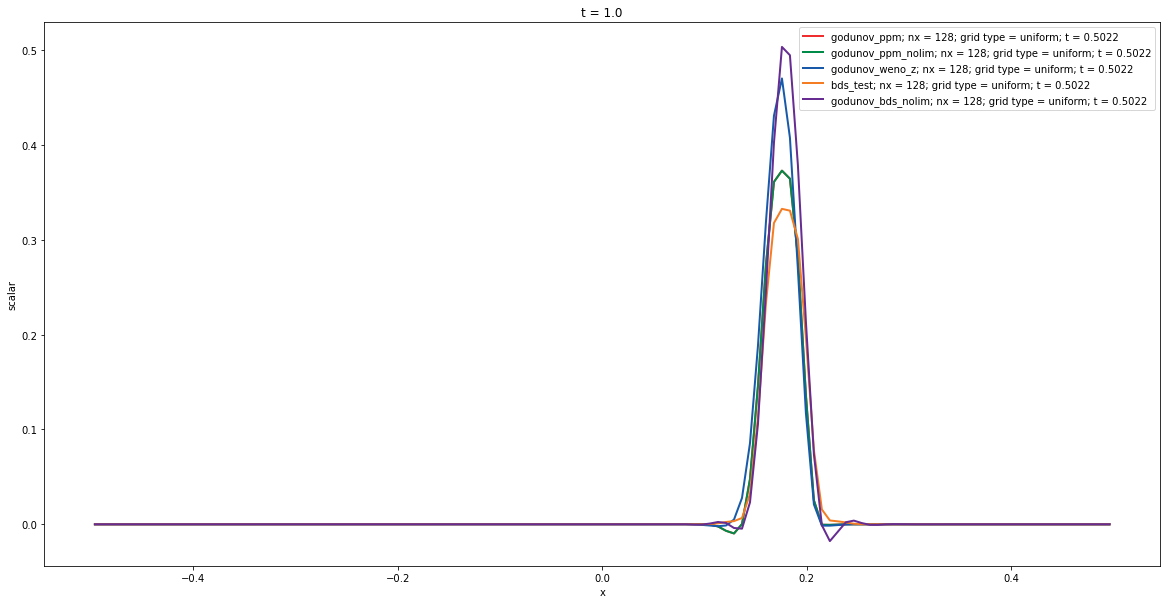

In [36]:
methods = ['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','bds_test','godunov_bds_nolim']; grid_sizes = [128]; grid_type = 'uniform'; ray_start = (-0.5,0.25*math.sin(math.pi/4),0); ray_end = (0.5,0.25*math.sin(math.pi/4),0)
fig,ax = plt.subplots(figsize=(20,10))
postprocess_dist(twodimgaussianpulse_45_045.name,-1,root_dir,methods,[grid_type],[grid_sizes[0]],ax,linestyle_list,color_list,[2.0],plotting=True,ray_start=ray_start, ray_end=ray_end,line_configuration=2,print_dir=True)
ax.legend()
# ax.set_xlim((0.0,0.5))
ax.set_xlabel('x')
ax.set_ylabel('scalar')
ax.set_title('t = 1.0')

### 45 degrees; CFL = 0.45

In [53]:
%%capture
plt.rcParams["animation.html"] = "jshtml"
methods = ['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','godunov_bds','godunov_bds_nolim']; grid_sizes = [128]; grid_type = 'uniform'; ray_start = (-0.5,-0.5,0); ray_end = (0.5,0.5,0)
sliceplotsize=15

fig, lines, slp = setup_animation_fig(twodimgaussianpulse_45_045, root_dir, methods, grid_sizes, grid_type, ['solid'], color_list, sliceplotsize=sliceplotsize, with_error=False, max_level=1, with_exact_sol=False, scalar_ylim=[-0.1,1.4], error_ylim=[1e-6,1e0], ray_start=ray_start, ray_end=ray_end)

def animate(i):
    set_axes_data(slp, lines, i, twodimgaussianpulse_45_045, root_dir, methods, grid_sizes, grid_type, with_error=False, max_level=1, with_exact_sol=False, ray_start=ray_start, ray_end=ray_end)
    # figure size seems to be set to a square box with size dictated by sliceplot.set_figure_size(sliceplotsize). The command on the next line crops the box such that 
    fig.set_size_inches(1.25*sliceplotsize, 0.5*sliceplotsize) # figure size seems to be set to a square box with size dictated by sliceplot.set_figure_size(sliceplotsize). The command on this line crops the box such that 
    return lines

anim = FuncAnimation(fig, animate, init_func=init_animation, frames=30, interval=100, blit=True)

In [54]:
anim

Text(0.5, 1.0, 't = 1.0')

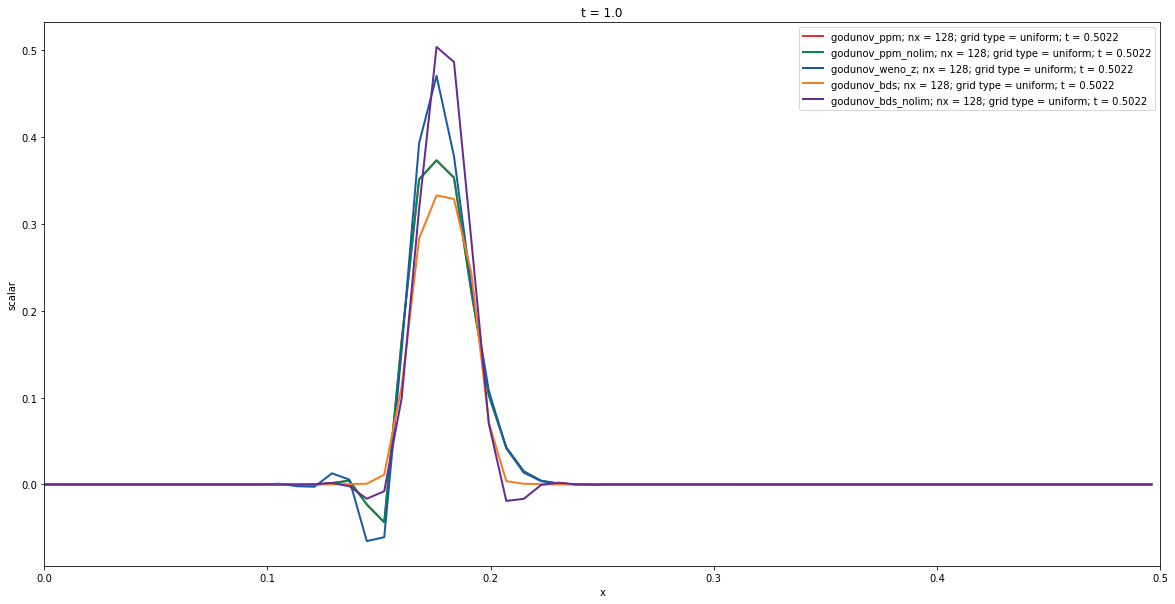

In [20]:
methods = ['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','godunov_bds','godunov_bds_nolim']; grid_sizes = [128]; grid_type = 'uniform'; ray_start = (-0.5,-0.5,0); ray_end = (0.5,0.5,0)
fig,ax = plt.subplots(figsize=(20,10))
postprocess_dist(twodimgaussianpulse_45_045.name,-1,root_dir,methods,[grid_type],[grid_sizes[0]],ax,linestyle_list,color_list,[2.0],plotting=True,ray_start=ray_start, ray_end=ray_end,line_configuration=2)
postprocess_dist(twodimgaussianpulse_45_045.name,-1,root_dir,methods,[grid_type],[grid_sizes[0]],ax,linestyle_list,color_list,[2.0],plotting=True,ray_start=ray_start, ray_end=ray_end,line_configuration=2)
ax.legend()
ax.set_xlim((0.0,0.5))
ax.set_xlabel('x')
ax.set_ylabel('scalar')
ax.set_title('t = 1.0')


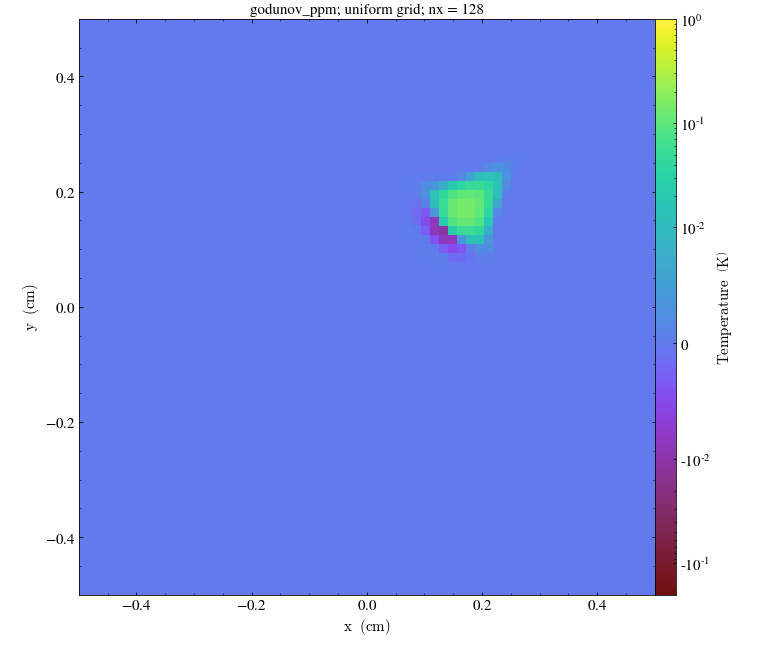

In [59]:
ds = yt.load('/scratch/dbeckers/scalar_advection/godunov_ppm/twodimgaussianpulse_45_degrees_CFL_0.45/uniform/nx_64/plt00050')
slp = yt.SlicePlot(ds, "z", ("gas","temperature"), fontsize=15, origin='native')
slp.set_zlim(("gas","temperature"), -0.2, 1.0)
slp.set_log(("gas","temperature"),True,linthresh=1e-2)
slp.annotate_title("godunov_ppm; uniform grid; nx = 128")
slp


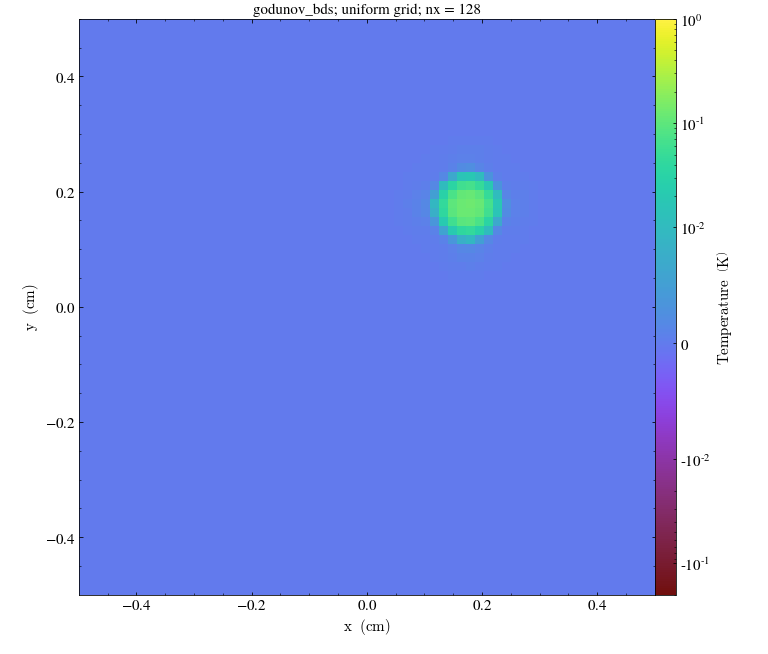

In [60]:
ds = yt.load('/scratch/dbeckers/scalar_advection/godunov_bds/twodimgaussianpulse_45_degrees_CFL_0.45/uniform/nx_64/plt00050')
slp = yt.SlicePlot(ds, "z", ("gas","temperature"), fontsize=15, origin='native')
slp.set_zlim(("gas","temperature"), -0.2, 1.0)
slp.set_log(("gas","temperature"),True,linthresh=1e-2)
slp.annotate_title("godunov_bds; uniform grid; nx = 128")
slp

### L2 error vs angle

Should I keep the CFL number constant or keep $\Delta t$ constant?

Text(0.5, 1.0, 't = 0.5')

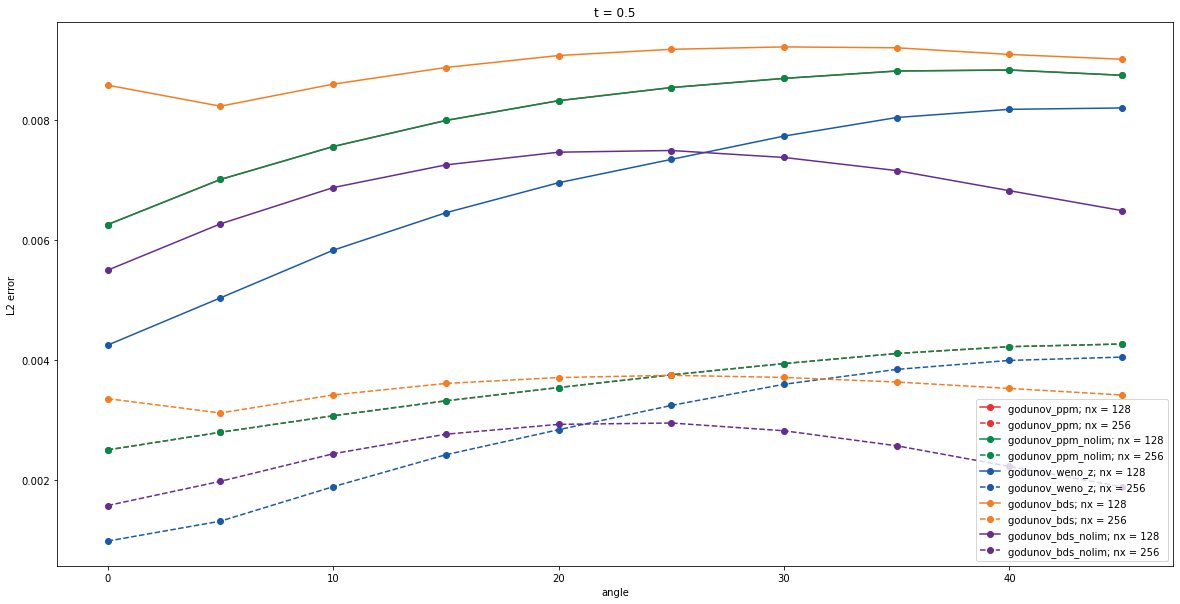

In [60]:
fig, ax = plt.subplots(figsize=(20,10))
angles = range(0,50,5); methods = ['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','godunov_bds','godunov_bds_nolim']; grid_sizes = [128,256];
for i_method in range(len(methods)):
    for i_grid_size in range(len(grid_sizes)):
        error_method = []
        for angle in angles:
            twodimgaussianpulse = TwoDimGaussianPulse(f'twodimgaussianpulse_{angle}_degrees_CFL_0.45',math.cos(angle*math.pi/180),math.sin(angle*math.pi/180),-0.25*math.cos(angle*math.pi/180),-0.25*math.sin(angle*math.pi/180),1.0,0.01,0.01,0,0)
            t_list, error_list = postprocess_error(twodimgaussianpulse.name,0.5,root_dir,[methods[i_method]],['uniform'],[grid_sizes[i_grid_size]],None,None,None,None,plotting=False)
            error_method.append(error_list[0][0][-1][-1])
        ax.plot(angles,error_method,label=f'{methods[i_method]}; nx = {grid_sizes[i_grid_size]}',marker='o',color=color_list[i_method],linestyle=linestyle_list[i_grid_size])
        
ax.legend()
ax.set_xlabel('angle')
ax.set_ylabel('L2 error')
ax.set_title('t = 0.5')

Text(0.5, 1.0, 't = 0.5')

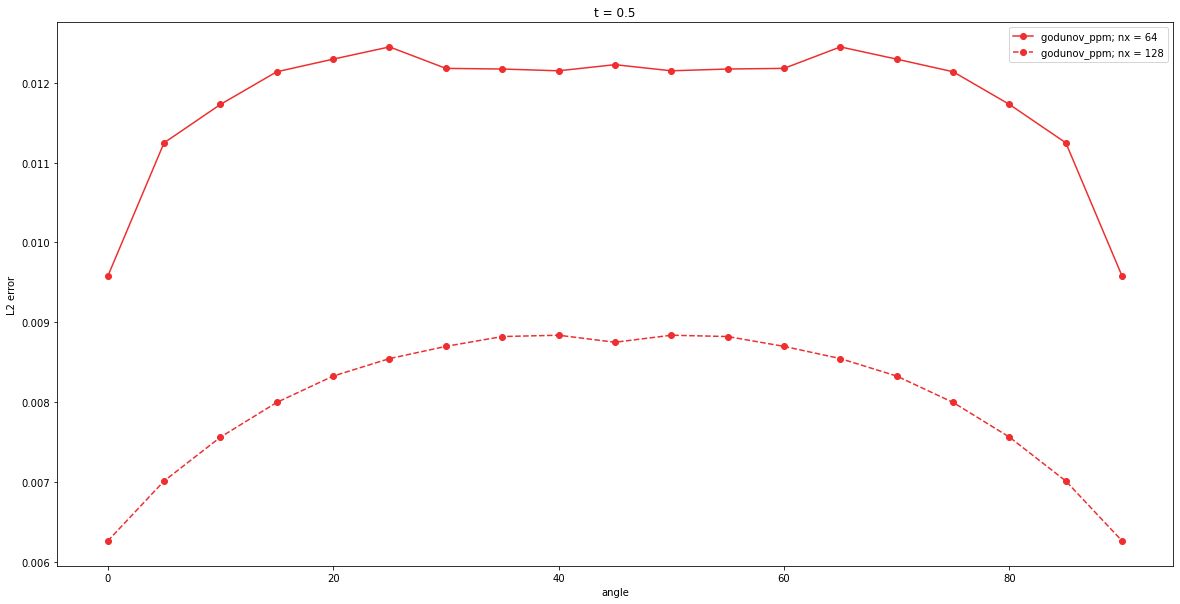

In [85]:
fig, ax = plt.subplots(figsize=(20,10))
angles = range(0,95,5); methods = ['godunov_ppm']; grid_sizes = [64,128];
for i_method in range(len(methods)):
    for i_grid_size in range(len(grid_sizes)):
        error_method = []
        for angle in angles:
            twodimgaussianpulse = TwoDimGaussianPulse(f'twodimgaussianpulse_{angle}_degrees_CFL_0.45',math.cos(angle*math.pi/180),math.sin(angle*math.pi/180),-0.25*math.cos(angle*math.pi/180),-0.25*math.sin(angle*math.pi/180),1.0,0.01,0.01,0,0)
            t_list, error_list = postprocess_error(twodimgaussianpulse.name,0.5,root_dir,[methods[i_method]],['uniform'],[grid_sizes[i_grid_size]],None,None,None,None,plotting=False)
            error_method.append(error_list[0][0][-1][-1])
        ax.plot(angles,error_method,label=f'{methods[i_method]}; nx = {grid_sizes[i_grid_size]}',marker='o',color=color_list[i_method],linestyle=linestyle_list[i_grid_size])
        
ax.legend()
ax.set_xlabel('angle')
ax.set_ylabel('L2 error')
ax.set_title('t = 0.5')

### Peak vs angle

Text(0.5, 1.0, 't = 0.5')

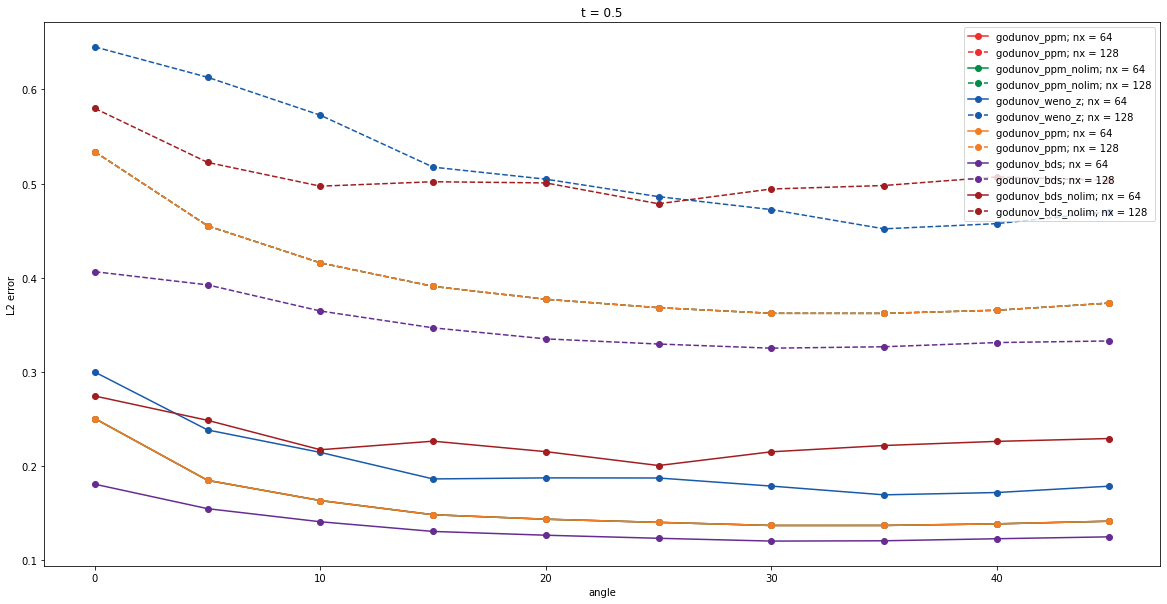

In [81]:
fig, ax = plt.subplots(figsize=(20,10))
angles = range(0,50,5); methods = ['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','godunov_ppm','godunov_bds','godunov_bds_nolim']; grid_sizes = [64,128];
for i_method in range(len(methods)):
    for i_grid_size in range(len(grid_sizes)):
        peak_method = []
        for angle in angles:
            twodimgaussianpulse = TwoDimGaussianPulse(f'twodimgaussianpulse_{angle}_degrees_CFL_0.45',math.cos(angle*math.pi/180),math.sin(angle*math.pi/180),-0.25*math.cos(angle*math.pi/180),-0.25*math.sin(angle*math.pi/180),1.0,0.01,0.01,0,0)
            t_list, ray_coord_list, s_list, ds_list = postprocess_dist(twodimgaussianpulse.name,-1,root_dir,[methods[i_method]],['uniform'],[grid_sizes[i_grid_size]],None,None,None,None,plotting=False,ray_start=(-0.5*math.cos(angle*math.pi/180),-0.5*math.sin(angle*math.pi/180),0),ray_end=(0.5*math.cos(angle*math.pi/180),0.5*math.sin(angle*math.pi/180),0))
            peak_method.append(max(s_list[0][0]))
        ax.plot(angles,peak_method,label=f'{methods[i_method]}; nx = {grid_sizes[i_grid_size]}',marker='o',color=color_list[i_method],linestyle=linestyle_list[i_grid_size])
        
ax.legend()
ax.set_xlabel('angle')
ax.set_ylabel('L2 error')
ax.set_title('t = 0.5')

### 45 degrees; CFL = 1.0

In [24]:
%%capture
plt.rcParams["animation.html"] = "jshtml"
methods = ['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','godunov_bds']; grid_sizes = [128]; grid_type = 'uniform'; ray_start = (-0.5,-0.5,0); ray_end = (1,0.5,0)
sliceplotsize=15

fig, lines, slp = setup_animation_fig(twodimgaussianpulse_45_1, root_dir, methods, grid_sizes, grid_type, ['solid'], color_list, sliceplotsize=sliceplotsize, with_error=True, max_level=1, with_exact_sol=True, scalar_ylim=[-0.1,1.4], error_ylim=[1e-6,1e0], ray_start=ray_start, ray_end=ray_end)

def animate(i):
    set_axes_data(slp, lines, i, twodimgaussianpulse_45_1, methods, grid_sizes, grid_type, with_error=False, max_level=1, with_exact_sol=False, ray_start=ray_start, ray_end=ray_end)
    # figure size seems to be set to a square box with size dictated by sliceplot.set_figure_size(sliceplotsize). The command on the next line crops the box such that 
    fig.set_size_inches(1.25*sliceplotsize, 0.5*sliceplotsize) # figure size seems to be set to a square box with size dictated by sliceplot.set_figure_size(sliceplotsize). The command on this line crops the box such that 
    return lines

anim = FuncAnimation(fig, animate, init_func=init_animation, frames=31, interval=100, blit=True)

In [ ]:
anim

# Fine-to-coarse grid

### 45 degrees; CFL = 0.45

In [86]:
%%capture
plt.rcParams["animation.html"] = "jshtml"
methods = ['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','godunov_bds','godunov_bds','godunov_bds_nolim']; grid_sizes = [128]; grid_type = 'fine_to_coarse'; ray_start = (-0.5,-0.5,0); ray_end = (0.5,0.5,0)
sliceplotsize=15

fig, lines, slp = setup_animation_fig(twodimgaussianpulse_45_045, root_dir, methods, grid_sizes, grid_type, ['solid'], color_list, sliceplotsize=sliceplotsize, with_error=False, max_level=1, with_exact_sol=False, scalar_ylim=[-0.1,1.4], error_ylim=[1e-6,1e0], ray_start=ray_start, ray_end=ray_end)

def animate(i):
    set_axes_data(slp, lines, i, twodimgaussianpulse_45_045, root_dir, methods, grid_sizes, grid_type, with_error=False, max_level=1, with_exact_sol=False, ray_start=ray_start, ray_end=ray_end)
    # figure size seems to be set to a square box with size dictated by sliceplot.set_figure_size(sliceplotsize). The command on the next line crops the box such that 
    fig.set_size_inches(1.25*sliceplotsize, 0.5*sliceplotsize) # figure size seems to be set to a square box with size dictated by sliceplot.set_figure_size(sliceplotsize). The command on this line crops the box such that 
    return lines

anim = FuncAnimation(fig, animate, init_func=init_animation, frames=30, interval=100, blit=True)

In [87]:
anim

### 45 degrees; CFL = 1.0

In [25]:
%%capture
plt.rcParams["animation.html"] = "jshtml"
methods = ['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','godunov_bds']; grid_sizes = [128]; grid_type = 'fine_to_coarse'; ray_start = (-0.5,-0.5,0); ray_end = (0.5,0.5,0)
sliceplotsize=15

fig, lines, slp = setup_animation_fig(twodimgaussianpulse_45_1, root_dir_angles, methods, grid_sizes, grid_type, ['solid'], color_list, sliceplotsize=sliceplotsize, with_error=False, max_level=1, with_exact_sol=False, scalar_ylim=[-0.1,1.4], error_ylim=[1e-6,1e0], ray_start=ray_start, ray_end=ray_end)

def animate(i):
    set_axes_data(slp, lines, i, twodimgaussianpulse_45_1, root_dir_angles, methods, grid_sizes, grid_type, with_error=False, max_level=1, with_exact_sol=False, ray_start=ray_start, ray_end=ray_end)
    # figure size seems to be set to a square box with size dictated by sliceplot.set_figure_size(sliceplotsize). The command on the next line crops the box such that 
    fig.set_size_inches(1.25*sliceplotsize, 0.5*sliceplotsize) # figure size seems to be set to a square box with size dictated by sliceplot.set_figure_size(sliceplotsize). The command on this line crops the box such that 
    return lines

anim = FuncAnimation(fig, animate, init_func=init_animation, frames=30, interval=100, blit=True)

In [ ]:
anim

### error vs angle; CFL = 0.45

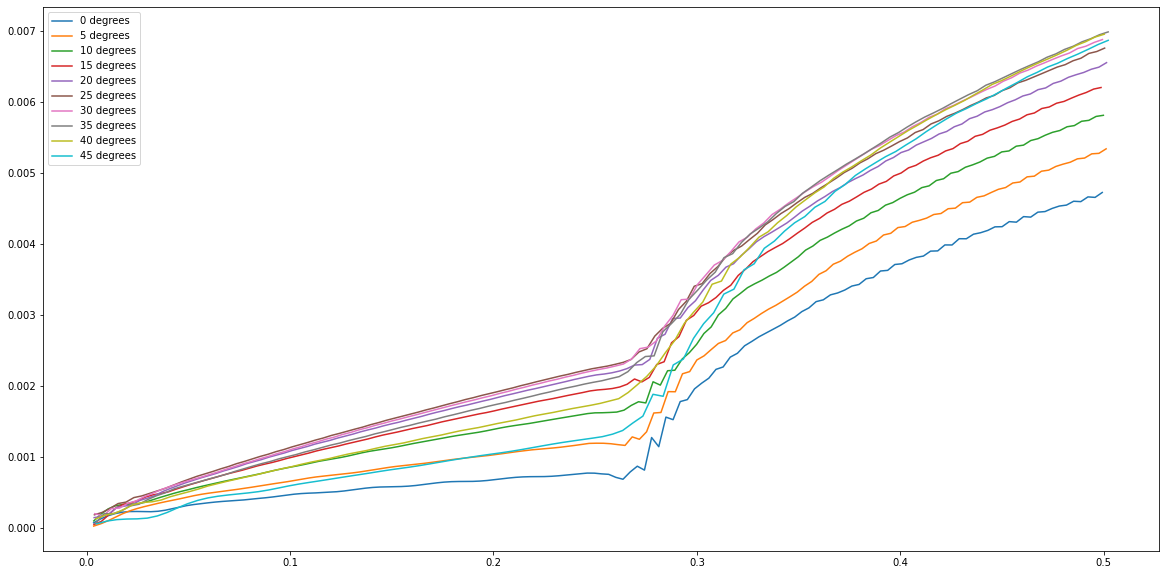

In [136]:
fig, ax = plt.subplots(figsize=(20,10))
for angle in range(0,50,5):
    twodimgaussianpulse = TwoDimGaussianPulse(f'twodimgaussianpulse_{angle}_degrees_CFL_0.45',math.cos(angle*math.pi/180),math.sin(angle*math.pi/180),-0.25*math.cos(angle*math.pi/180),-0.25*math.sin(angle*math.pi/180),1.0,0.01,0.01,0,0)
    t_list, error_list = postprocess_error(twodimgaussianpulse.name,0.5,root_dir_angles,['godunov_ppm'],['fine_to_coarse'],[128],None,None,None,None,plotting=False)
    ax.plot(t_list[0][0],error_list[0][0][-1],label=f'{angle} degrees')
ax.legend()

Text(0.5, 1.0, 't = 0.5')

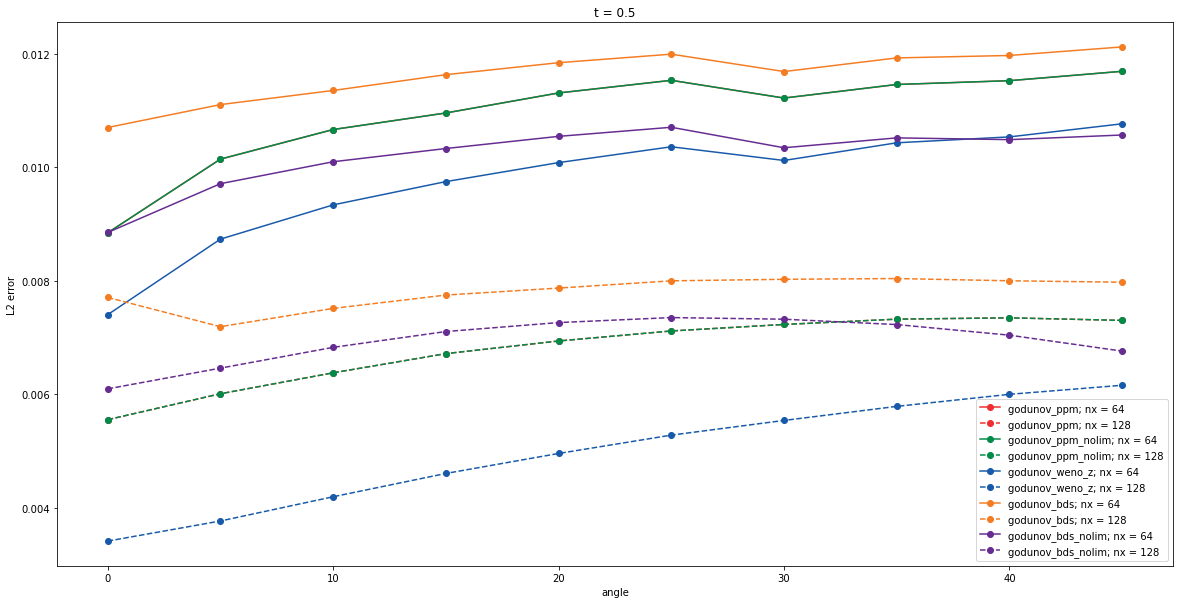

In [90]:
fig, ax = plt.subplots(figsize=(20,10))
angles = range(0,50,5); methods = ['godunov_ppm','godunov_ppm_nolim','godunov_weno_z','godunov_bds','godunov_bds_nolim']; grid_sizes = [64,128];
for i_method in range(len(methods)):
    for i_grid_size in range(len(grid_sizes)):    
        error_method = []
        for angle in angles:
            twodimgaussianpulse = TwoDimGaussianPulse(f'twodimgaussianpulse_{angle}_degrees_CFL_0.45',math.cos(angle*math.pi/180),math.sin(angle*math.pi/180),-0.25*math.cos(angle*math.pi/180),-0.25*math.sin(angle*math.pi/180),1.0,0.01,0.01,0,0)
            t_list, error_list = postprocess_error(twodimgaussianpulse.name,0.5,root_dir,[methods[i_method]],['fine_to_coarse'],[grid_sizes[i_grid_size]],None,None,None,None,plotting=False)
            error_method.append(error_list[0][0][-1][-1])
        ax.plot(angles,error_method,label=f'{methods[i_method]}; nx = {grid_sizes[i_grid_size]}',marker='o',color=color_list[i_method],linestyle=linestyle_list[i_grid_size])
        
ax.legend()
ax.set_xlabel('angle')
ax.set_ylabel('L2 error')
ax.set_title('t = 0.5')

In [23]:
ds1 = yt.load('/home/dbeckers/tests/scalar_advection/godunov_ppm/twodimgaussianpulse_45_degrees_CFL_0.45/uniform/nx_64/plt00100')
ds2 = yt.load('/home/dbeckers/tests/scalar_advection/mol_central/twodimgaussianpulse_u_0.707_v_0.707/uniform/nx_64/plt00100')
sl2 = ds2.r[:, :, 0]
# ds = yt.load('/home/dbeckers/tests/scalar_advection/test/plt00100')


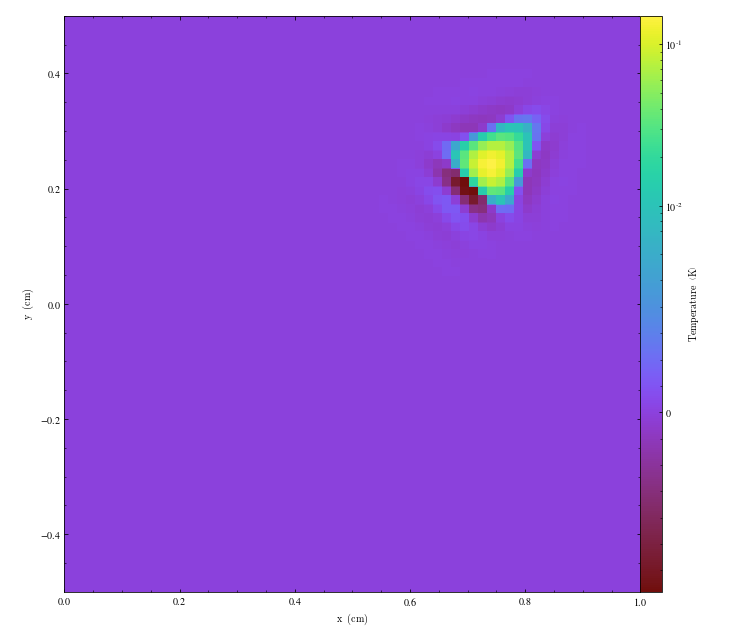

In [211]:
slp2


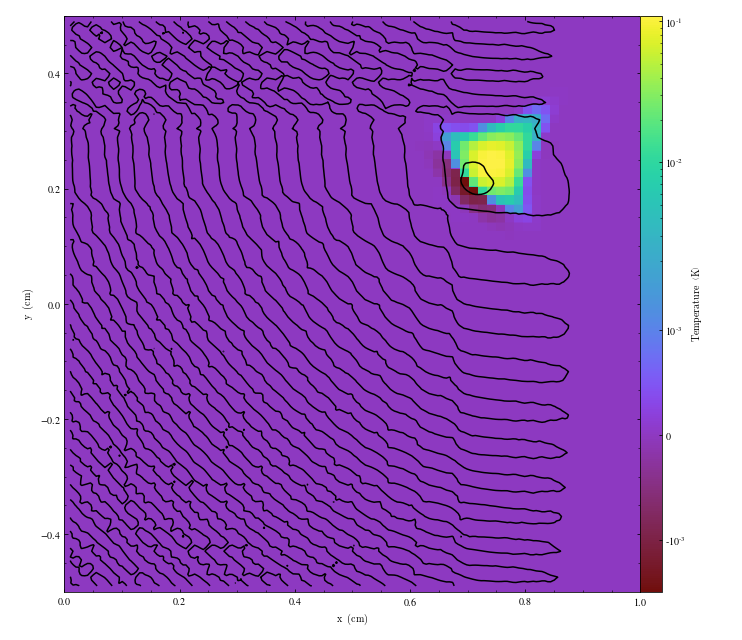

In [24]:
slp1 = yt.SlicePlot(ds1, "z", ("gas","temperature"), fontsize=10, origin='native')
slp2 = yt.SlicePlot(ds2, "z", ("gas","temperature"), fontsize=10, origin='native')

slp1.annotate_contour(("gas", "temperature"),ncont=10,clim=(0.001,0.8),factor=4,data_source=sl2,take_log=False)

In [204]:
slp.data_source

YTSlice (plt00100): , axis=2, coord=0.0 cm

In [107]:
slp = yt.SlicePlot(ds, "z", ("gas","temperature"), fontsize=10, origin='native')

In [135]:
sl = ds.r[:, :, 0]

In [ ]:
sl.